In [3]:
!pip install pyvirtualdisplay matplotlib seaborn pandas numpy pathlib gym
!sudo apt-get install xvfb
!apt-get install x11-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.8 [784 kB]
Fetched 784 kB in 0s (8,243 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package xvfb.
(Reading database ... 145480 files and director

##Librairies and helper functions

In [4]:
from pathlib import Path
from gym import envs
import base64 
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import gym
from gym.wrappers import Monitor
from pprint import pprint
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output
# The following code is will be used to visualize the environments.

def show_video(directory):
    html = []
    for mp4 in Path(directory).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))
    
display = Display(visible=0, size=(1400, 900))
display.start();

def make_seed(seed):
    np.random.seed(seed=seed)
    torch.manual_seed(seed=seed)

##OpenAI gym environments

In [5]:
envids = [spec.id for spec in envs.registry.all()]
for envid in sorted(envids):
    print(envid)

Acrobot-v1
Adventure-ram-v0
Adventure-ram-v4
Adventure-ramDeterministic-v0
Adventure-ramDeterministic-v4
Adventure-ramNoFrameskip-v0
Adventure-ramNoFrameskip-v4
Adventure-v0
Adventure-v4
AdventureDeterministic-v0
AdventureDeterministic-v4
AdventureNoFrameskip-v0
AdventureNoFrameskip-v4
AirRaid-ram-v0
AirRaid-ram-v4
AirRaid-ramDeterministic-v0
AirRaid-ramDeterministic-v4
AirRaid-ramNoFrameskip-v0
AirRaid-ramNoFrameskip-v4
AirRaid-v0
AirRaid-v4
AirRaidDeterministic-v0
AirRaidDeterministic-v4
AirRaidNoFrameskip-v0
AirRaidNoFrameskip-v4
Alien-ram-v0
Alien-ram-v4
Alien-ramDeterministic-v0
Alien-ramDeterministic-v4
Alien-ramNoFrameskip-v0
Alien-ramNoFrameskip-v4
Alien-v0
Alien-v4
AlienDeterministic-v0
AlienDeterministic-v4
AlienNoFrameskip-v0
AlienNoFrameskip-v4
Amidar-ram-v0
Amidar-ram-v4
Amidar-ramDeterministic-v0
Amidar-ramDeterministic-v4
Amidar-ramNoFrameskip-v0
Amidar-ramNoFrameskip-v4
Amidar-v0
Amidar-v4
AmidarDeterministic-v0
AmidarDeterministic-v4
AmidarNoFrameskip-v0
AmidarNoFrames

In [6]:
# We load CartPole-v1
env = gym.make('CartPole-v1')
# We wrap it in order to save our experiment on a file.
env = Monitor(env, "./gym-results", force=True)

In [7]:
done = False
obs = env.reset()
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    info='Action: '+str(action)+' Next state: '+str(obs)+ ' Reward: '+str(reward)
    print(info)
env.close()
show_video("./gym-results")

Action: 1 Next state: [-0.02361191  0.20578667  0.02191427 -0.26993028] Reward: 1.0
Action: 1 Next state: [-0.01949618  0.40058915  0.01651567 -0.55562157] Reward: 1.0
Action: 1 Next state: [-0.01148439  0.59547537  0.00540323 -0.84305564] Reward: 1.0
Action: 0 Next state: [ 4.25114046e-04  4.00280098e-01 -1.14578790e-02 -5.48678460e-01] Reward: 1.0
Action: 0 Next state: [ 0.00843072  0.20532096 -0.02243145 -0.2596275 ] Reward: 1.0
Action: 1 Next state: [ 0.01253714  0.40075584 -0.027624   -0.55930035] Reward: 1.0
Action: 0 Next state: [ 0.02055225  0.20603229 -0.03881001 -0.27544689] Reward: 1.0
Action: 0 Next state: [ 0.0246729   0.01148493 -0.04431894  0.00474712] Reward: 1.0
Action: 1 Next state: [ 0.0249026   0.20721354 -0.044224   -0.301583  ] Reward: 1.0
Action: 0 Next state: [ 0.02904687  0.01274889 -0.05025566 -0.02316884] Reward: 1.0
Action: 0 Next state: [ 0.02930184 -0.18161768 -0.05071904  0.25324396] Reward: 1.0
Action: 1 Next state: [ 0.02566949  0.01419042 -0.04565416 -

##REINFORCE

In [20]:
class PolicyModel(nn.Module):
    def __init__(self, dim_observation, n_actions):
        super(PolicyModel, self).__init__()
        
        self.n_actions = n_actions
        self.dim_observation = dim_observation
        
        self.net = nn.Sequential(
            nn.Linear(in_features=self.dim_observation, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=self.n_actions),
            nn.Softmax(dim=0)
        )
        
    def forward(self, state):
        return self.net(state)
    
    def select_action(self, state):
        action = torch.multinomial(self.forward(state), 1)
        return action

class BaseAgent:
    
    def __init__(self, config):
        self.config = config
        self.env = gym.make(config['env_id'])
        make_seed(config['seed'])
        self.env.seed(config['seed'])
        self.model = PolicyModel(self.env.observation_space.shape[0], self.env.action_space.n)
        self.gamma = config['gamma']
        
        # the optimizer used by PyTorch (Stochastic Gradient, Adagrad, Adam, etc.)
        self.optimizer = torch.optim.Adam(self.model.net.parameters(), lr=config['learning_rate'])
        self.monitor_env = Monitor(env, "./gym-results", force=True, video_callable=lambda episode: True)
    
    # Method to implement
    def _compute_returns(self, rewards):
        """Returns the cumulative discounted rewards at each time step

        Parameters
        ----------
        rewards : array
            The array of rewards of one episode

        Returns
        -------
        array
            The cumulative discounted rewards at each time step
            
        Example
        -------
        for rewards=[1, 2, 3] this method outputs [1 + 2 * gamma + 3 * gamma**2, 2 + 3 * gamma, 3] 
        """
        raise NotImplementedError
        
    # Method to implement
    def optimize_model(self, n_trajectories):
        """Perform a gradient update using n_trajectories

        Parameters
        ----------
        n_trajectories : int
            The number of trajectories used to approximate the expectation card(D) in the formula above
        
        Returns
        -------
        array
            The cumulative discounted rewards of each trajectory
        """
        raise NotImplementedError

    
    def train(self, n_trajectories, n_update):
        """Training method

        Parameters
        ----------
        n_trajectories : int
            The number of trajectories used to approximate the expected gradient
        n_update : int
            The number of gradient updates
            
        """
        
        rewards = []
        for episode in range(n_update):
            rewards.append(self.optimize_model(n_trajectories))
            print(f'Episode {episode + 1}/{n_update}: rewards {round(rewards[-1].mean(), 2)} +/- {round(rewards[-1].std(), 2)}')
        
        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards[i]) for i in range(len(rewards))))), columns=['Epoch', 'Reward'])
        sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd');
        
    def evaluate(self, render=False):
        """Evaluate the agent on a single trajectory            
        """
        with torch.no_grad():
            observation = self.monitor_env.reset()
            observation = torch.tensor(observation, dtype=torch.float)
            reward_episode = 0
            done = False
                
            while not done:
                action = self.model.select_action(observation)
                observation, reward, done, info = self.monitor_env.step(int(action))
                observation = torch.tensor(observation, dtype=torch.float)
                reward_episode += reward
            
            self.monitor_env.close()
            if render:
                show_video("./gym-results")
                print(f'Reward: {reward_episode}')
            print(f'Reward: {reward_episode}')

In [21]:
class REINFORCE(BaseAgent):
    
    def __init__(self, config):
        super(REINFORCE, self).__init__(config)

    def _compute_returns(self, rewards):
        returns =[]
        for t in range(len(rewards)):
            returns.append(np.sum([self.gamma**(k-t)*rewards[k] for k in range(t,len(rewards))]))
        return np.array(returns)

    def optimize_model(self, n_trajectories):
        reward_trajectories =[]
        loss = 0
        for i in range(n_trajectories):
          rewards =[]
          observation = self.env.reset()
          policy =[]
          done = False
          while not done:
            observation = torch.tensor(observation, dtype=torch.float)
            action = self.model.select_action(observation)
            proba = self.model(observation)[int(action)]
            policy.append(proba)
            observation, reward, done, info = self.env.step(int(action))
            rewards.append(reward)
          reward_trajectories.append(self._compute_returns(rewards)[0])
          for t in range(len(rewards)):
            loss -=torch.log(policy[t])*self._compute_returns(rewards)[t]/n_trajectories
        env.close()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return np.array(reward_trajectories)

In [22]:
env_id = 'CartPole-v1'
learning_rate = 0.01
gamma = 1 
seed = 1235

config = {
    'env_id': env_id,
    'learning_rate': learning_rate,
    'seed': seed,
    'gamma': gamma
}

print("Current config is:")
print(config)


Current config is:
{'env_id': 'CartPole-v1', 'learning_rate': 0.01, 'seed': 1235, 'gamma': 1}


Episode 1/50: rewards 21.38 +/- 11.01
Episode 2/50: rewards 19.28 +/- 6.62
Episode 3/50: rewards 22.04 +/- 15.23
Episode 4/50: rewards 20.18 +/- 7.51
Episode 5/50: rewards 24.18 +/- 12.17
Episode 6/50: rewards 24.26 +/- 12.53
Episode 7/50: rewards 23.12 +/- 10.91
Episode 8/50: rewards 24.16 +/- 12.7
Episode 9/50: rewards 24.46 +/- 14.41
Episode 10/50: rewards 26.34 +/- 15.02
Episode 11/50: rewards 27.06 +/- 10.58
Episode 12/50: rewards 31.02 +/- 13.39
Episode 13/50: rewards 30.32 +/- 15.73
Episode 14/50: rewards 33.76 +/- 19.97
Episode 15/50: rewards 29.24 +/- 14.12
Episode 16/50: rewards 38.18 +/- 20.01
Episode 17/50: rewards 33.14 +/- 16.21
Episode 18/50: rewards 37.44 +/- 21.06
Episode 19/50: rewards 45.0 +/- 31.12
Episode 20/50: rewards 43.62 +/- 23.3
Episode 21/50: rewards 46.34 +/- 24.43
Episode 22/50: rewards 44.68 +/- 18.43
Episode 23/50: rewards 51.5 +/- 24.0
Episode 24/50: rewards 43.54 +/- 22.24
Episode 25/50: rewards 52.28 +/- 24.84
Episode 26/50: rewards 55.5 +/- 20.88
Epi

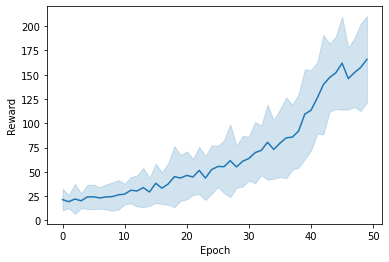

In [23]:
agent = REINFORCE(config)
agent.train(n_trajectories=50, n_update=50)

In [24]:
agent.evaluate(render=True)

Reward: 97.0
Reward: 97.0


## Advantage Actor Critic (A2C)

In [28]:
class ValueNetwork(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
    
    def predict(self, x):
        return self(x).detach().numpy()[0]

class ActorNetwork(nn.Module):

    def __init__(self, input_size, hidden_size, action_size):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.softmax(self.fc3(out), dim=-1)
        return out
    
    def select_action(self, x):
        return torch.multinomial(self.forward(x), 1).detach().numpy()

class A2CAgent:

    def __init__(self, config):
        self.config = config
        self.env = gym.make(config['env_id'])
        make_seed(config['seed'])
        self.env.seed(config['seed'])
        self.monitor_env = Monitor(self.env, "./gym-results", force=True, video_callable=lambda episode: True)
        self.gamma = config['gamma']
        
        # Our two networks
        self.value_network = ValueNetwork(self.env.observation_space.shape[0], 16, 1)
        self.actor_network = ActorNetwork(self.env.observation_space.shape[0], 16, self.env.action_space.n)
        
        # Their optimizers
        self.value_network_optimizer = optim.RMSprop(self.value_network.parameters(), lr=config['value_network']['learning_rate'])
        self.actor_network_optimizer = optim.RMSprop(self.actor_network.parameters(), lr=config['actor_network']['learning_rate'])
        
    # Hint: use it during training_batch
    def _returns_advantages(self, rewards, dones, values, next_value):
        """Returns the cumulative discounted rewards at each time step

        Parameters
        ----------
        rewards : array
            An array of shape (batch_size,) containing the rewards given by the env
        dones : array
            An array of shape (batch_size,) containing the done bool indicator given by the env
        values : array
            An array of shape (batch_size,) containing the values given by the value network
        next_value : float
            The value of the next state given by the value network
        
        Returns
        -------
        returns : array
            The cumulative discounted rewards
        advantages : array
            The advantages
        """
        batch_size=len(rewards)
        returns=np.zeros(batch_size)
        for t in range(batch_size):
          p=t 
          while  p<batch_size and not dones[p]:
            returns[t] += rewards[p]*self.gamma**(p-t) 
            p = p+1
          if p==batch_size and not dones[-1]:
            returns[t] += next_value*self.gamma**(p-t)
        advantages = returns-values
        return returns, advantages

    def training_batch(self, epochs, batch_size):
        """Perform a training by batch

        Parameters
        ----------
        epochs : int
            Number of epochs
        batch_size : int
            The size of a batch
        """
        episode_count = 0
        actions = np.empty((batch_size,), dtype=np.int)
        dones = np.empty((batch_size,), dtype=np.bool)
        rewards, values = np.empty((2, batch_size), dtype=np.float)
        observations = np.empty((batch_size,) + self.env.observation_space.shape, dtype=np.float)
        observation = self.env.reset()
        rewards_test = []

        for epoch in range(epochs):
            # Lets collect one batch
            for i in range(batch_size):
              observations[i] = observation
              values[i] =  self.value_network(torch.tensor(observation,dtype=torch.float))
              actions[i] = self.actor_network.select_action(torch.tensor(observation,dtype=torch.float))
              observation,rewards[i],dones[i],info = self.env.step(int(actions[i]))
              if dones[i]:
                observation = self.env.reset()
                
            # If our epiosde didn't end on the last step we need to compute the value for the last state
            if dones[-1]:
                next_value = 0
            else:
                next_value = self.value_network(torch.tensor(observation,dtype=torch.float))
            
            
            # Update episode_count
            episode_count += sum(dones)


            # Compute returns and advantages
            returns, advantages = self._returns_advantages(rewards, dones, values, next_value)

            # Learning step !
            self.optimize_model(observations, actions, returns, advantages)

            # Test it every 50 epochs
            if epoch % 50 == 0 or epoch == epochs - 1:
                rewards_test.append(np.array([self.evaluate() for _ in range(50)]))
                print(f'Epoch {epoch}/{epochs}: Mean rewards: {round(rewards_test[-1].mean(), 2)}, Std: {round(rewards_test[-1].std(), 2)}')

                # Early stopping
                if rewards_test[-1].mean() > 490 and epoch != epochs -1:
                    print('Early stopping !')
                    break
                observation = self.env.reset()
                    
        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards_test[i]) for i in range(len(rewards_test))))), columns=['Epoch', 'Reward'])
        sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd');
        
        print(f'The trainnig was done over a total of {episode_count} episodes')

    def optimize_model(self, observations, actions, returns, advantages):
        actions = F.one_hot(torch.tensor(actions), self.env.action_space.n)
        returns = torch.tensor(returns[:, None], dtype=torch.float)
        advantages = torch.tensor(advantages, dtype=torch.float)
        observations = torch.tensor(observations, dtype=torch.float)

        # MSE for the values
        values = self.value_network(torch.tensor(observations, dtype=torch.float)) 
        loss_value = F.mse_loss(values,returns)
        self.value_network_optimizer.zero_grad()
        loss_value.backward()
        self.value_network_optimizer.step()
        # Actor & Entropy loss
        loss_actor = 0
        for t in range(len(observations)):
          loss_actor -= torch.log(self.actor_network(observations[t])[int(actions[t][1])])*advantages[t]/len(advantages)
        self.actor_network_optimizer.zero_grad()
        loss_actor.backward()
        self.actor_network_optimizer.step()
        return loss_value, loss_actor

    def evaluate(self, render=False):
        env = self.monitor_env if render else self.env
        observation = env.reset()
        observation = torch.tensor(observation, dtype=torch.float)
        reward_episode = 0
        done = False

        while not done:
            policy = self.actor_network(observation)
            action = torch.multinomial(policy, 1)
            observation, reward, done, info = env.step(int(action))
            observation = torch.tensor(observation, dtype=torch.float)
            reward_episode += reward
            
        env.close()
        if render:
            show_video("./gym-results")
            print(f'Reward: {reward_episode}')
        return reward_episode

In [29]:
env_id = 'CartPole-v1'
value_learning_rate = 0.001
actor_learning_rate = 0.001
gamma = 0.99
entropy = 1
seed = 1

config_a2c = {
    'env_id': env_id,
    'gamma': gamma,
    'seed': seed,
    'value_network': {'learning_rate': value_learning_rate},
    'actor_network': {'learning_rate': actor_learning_rate},
    'entropy': entropy
}

print("Current config_a2c is:")
pprint(config_a2c)

Current config_a2c is:
{'actor_network': {'learning_rate': 0.001},
 'entropy': 1,
 'env_id': 'CartPole-v1',
 'gamma': 0.99,
 'seed': 1,
 'value_network': {'learning_rate': 0.001}}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0/1000: Mean rewards: 23.62, Std: 11.63
Epoch 50/1000: Mean rewards: 41.06, Std: 21.07
Epoch 100/1000: Mean rewards: 51.36, Std: 23.18
Epoch 150/1000: Mean rewards: 98.56, Std: 56.51
Epoch 200/1000: Mean rewards: 191.3, Std: 93.96
Epoch 250/1000: Mean rewards: 230.28, Std: 106.54
Epoch 300/1000: Mean rewards: 220.8, Std: 114.15
Epoch 350/1000: Mean rewards: 226.6, Std: 96.9
Epoch 400/1000: Mean rewards: 339.3, Std: 130.57
Epoch 450/1000: Mean rewards: 423.84, Std: 108.03
Epoch 500/1000: Mean rewards: 408.6, Std: 117.29
Epoch 550/1000: Mean rewards: 406.1, Std: 115.66
Epoch 600/1000: Mean rewards: 424.04, Std: 112.2
Epoch 650/1000: Mean rewards: 434.66, Std: 99.78
Epoch 700/1000: Mean rewards: 379.12, Std: 104.09
Epoch 750/1000: Mean rewards: 455.52, Std: 84.93
Epoch 800/1000: Mean rewards: 452.52, Std: 87.58
Epoch 850/1000: Mean rewards: 451.22, Std: 91.5
Epoch 900/1000: Mean rewards: 458.82, Std: 92.52
Epoch 950/1000: Mean rewards: 458.82, Std: 92.94
Epoch 999/1000: Mean rewards

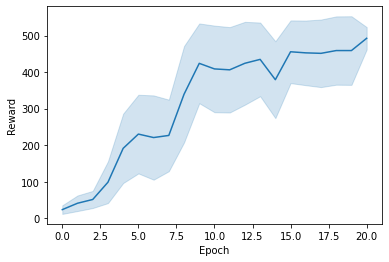

In [30]:
agent = A2CAgent(config_a2c)
rewards = agent.training_batch(1000, 256)

In [34]:
agent.evaluate(render=True)

Reward: 500.0


500.0